In [1]:
import os
import tensorflow as tf
import numpy as np
from keras.models import Model, load_model
from keras.layers import Input, Dense, Activation, BatchNormalization, Conv2D, SeparableConv2D, concatenate, MaxPooling2D, GlobalAveragePooling2D 
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import matplotlib.pyplot as plt
import h5py

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [5]:
def normalize(X_train,X_test):
        #this function normalize inputs for zero mean and unit variance
        # it is used when training a model.
        # Input: training set and test set
        # Output: normalized training set and test set according to the trianing set statistics.
        mean = np.mean(X_train,axis=(0,1,2,3))
        std = np.std(X_train, axis=(0, 1, 2, 3))
        X_train = (X_train-mean)/(std+1e-7)
        X_test = (X_test-mean)/(std+1e-7)
        return X_train, X_test

In [6]:
x_train, x_test = normalize(x_train, x_test)

In [7]:
keys = np.unique(y_test)
keys

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
values = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
classes = dict(zip(keys,values))
classes

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


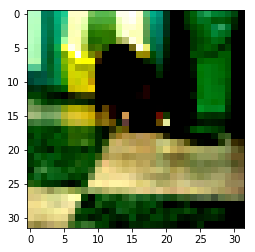

'cat'

In [9]:
nb = np.random.choice(50000)
plt.imshow(x_train[nb], interpolation='nearest')
plt.show()
classes[y_train[nb][0]]

In [10]:
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [11]:
def ddb_b(X_input, growth, repeat=6, **kwargs):
    X = X_input
    for i in range(repeat):
        X = Conv2D(growth, (1,1), strides = 1, **kwargs)(X_input)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        X = SeparableConv2D(growth, (3,3), strides=1, **kwargs)(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)
        
        X_input = concatenate([X_input, X], axis = -1)
    return X_input

In [12]:
def tinyDSOD_backbone(input_shape, l2):
    regul = regularizers.l2(l2)
    kwargs = {'padding':'same', 'kernel_regularizer':regul,'kernel_initializer':'glorot_uniform'}

    ### STEM ###
    # Convolution 1
    inp = Input(input_shape)
    X = Conv2D(64, (3,3), strides=2, **kwargs)(inp)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Convolution 2
    X = Conv2D(64, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Depth-wise seperable convolution 1
    X = SeparableConv2D(64, (3,3), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Convolution 3
    X = Conv2D(128, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Depth-wise seperable convolution 2
    X = SeparableConv2D(128, (3,3), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Pooling
    X = MaxPooling2D((2,2), strides=2, padding='same')(X)
    
    ### Extractor ###
    # Dense stage 0
    X = ddb_b(X, 32, repeat=4, **kwargs)
    
    # Transition layer 0
    X = Conv2D(128, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), strides=2, padding='same')(X)
    
    # Dense stage 1
    X = ddb_b(X, 48, repeat = 6, **kwargs)
    
    # Transition layer 1
    X = Conv2D(128, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2,2), strides=2, padding='same')(X)
    
    # Dense stage 2
    X = ddb_b(X, 64, repeat=6, **kwargs)
    
    # Transition layer 2
    X = Conv2D(256, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    # Dense stage 3
    X = ddb_b(X, 80, repeat=6, **kwargs)
    
    # Transition layer 3
    X = Conv2D(64, (1,1), strides=1, **kwargs)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    
    ### Classification layers ###
    X = GlobalAveragePooling2D()(X)
    X = Dense(10, activation='softmax', kernel_regularizer=regul, kernel_initializer='glorot_uniform')(X)
    
    ### Create Model ### 
    
    model = Model(inputs=inp, outputs=X, name='TinyDSOD_bb')
    
    return model

In [21]:
classification_model = tinyDSOD_backbone((32,32,3), l2=5e-4)

In [14]:
classification_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [15]:
 datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
        # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [22]:
learning_rate = 0.1
lr_drop = 20

#We create a checkpoint to save the best model and add an early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min')
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = LearningRateScheduler(lr_scheduler)
callbacks_list = [early_stop, reduce_lr]
    

print(model_name)
    
sgd = SGD(lr=learning_rate, momentum=0.9, decay=1e-6)
classification_model.compile(optimizer = sgd, loss = "categorical_crossentropy", metrics=['accuracy'])

classification_model.fit_generator(
                        datagen.flow(x_train, y_train, batch_size=128),
                        epochs=300,
                        validation_data=(x_test, y_test),
                        workers=4,
                        shuffle = True,
                        callbacks=callbacks_list)

classification_model.save_weights('cifar10_dsodtiny_bb.h5')

MODEL.h5
Epoch 1/300
391/391 [==============================] - 48s 123ms/step - loss: 3.0354 - acc: 0.4052 - val_loss: 2.7201 - val_acc: 0.4079
Epoch 2/300
391/391 [==============================] - 34s 87ms/step - loss: 2.0310 - acc: 0.5445 - val_loss: 1.9313 - val_acc: 0.5228
Epoch 3/300
391/391 [==============================] - 34s 87ms/step - loss: 1.5999 - acc: 0.5997 - val_loss: 2.0234 - val_acc: 0.4204
Epoch 4/300
391/391 [==============================] - 34s 87ms/step - loss: 1.3964 - acc: 0.6345 - val_loss: 1.5447 - val_acc: 0.5992
Epoch 5/300
391/391 [==============================] - 34s 88ms/step - loss: 1.2818 - acc: 0.6615 - val_loss: 1.4384 - val_acc: 0.6105
Epoch 6/300
391/391 [==============================] - 34s 88ms/step - loss: 1.2171 - acc: 0.6820 - val_loss: 1.7899 - val_acc: 0.5214
Epoch 7/300
391/391 [==============================] - 34s 87ms/step - loss: 1.1762 - acc: 0.6995 - val_loss: 1.4530 - val_acc: 0.6106
Epoch 8/300
391/391 [========================

391/391 [==============================] - 35s 89ms/step - loss: 0.4878 - acc: 0.9136 - val_loss: 0.6324 - val_acc: 0.8656
Epoch 62/300
391/391 [==============================] - 34s 87ms/step - loss: 0.4582 - acc: 0.9189 - val_loss: 0.6045 - val_acc: 0.8747
Epoch 63/300
391/391 [==============================] - 34s 87ms/step - loss: 0.4468 - acc: 0.9204 - val_loss: 0.6152 - val_acc: 0.8717
Epoch 64/300
391/391 [==============================] - 34s 88ms/step - loss: 0.4385 - acc: 0.9202 - val_loss: 0.6698 - val_acc: 0.8574
Epoch 65/300
391/391 [==============================] - 34s 88ms/step - loss: 0.4335 - acc: 0.9205 - val_loss: 0.6964 - val_acc: 0.8471
Epoch 66/300
391/391 [==============================] - 34s 87ms/step - loss: 0.4286 - acc: 0.9211 - val_loss: 0.7400 - val_acc: 0.8389
Epoch 67/300
391/391 [==============================] - 34s 88ms/step - loss: 0.4276 - acc: 0.9198 - val_loss: 0.6544 - val_acc: 0.8594
Epoch 68/300
391/391 [==============================] - 34s 8

391/391 [==============================] - 34s 88ms/step - loss: 0.1983 - acc: 0.9787 - val_loss: 0.5421 - val_acc: 0.8912
Epoch 122/300
391/391 [==============================] - 34s 87ms/step - loss: 0.1900 - acc: 0.9815 - val_loss: 0.5333 - val_acc: 0.8925
Epoch 123/300
391/391 [==============================] - 34s 87ms/step - loss: 0.1853 - acc: 0.9831 - val_loss: 0.5330 - val_acc: 0.8947
Epoch 124/300
391/391 [==============================] - 34s 88ms/step - loss: 0.1813 - acc: 0.9832 - val_loss: 0.5499 - val_acc: 0.8937
Epoch 125/300
391/391 [==============================] - 34s 87ms/step - loss: 0.1780 - acc: 0.9847 - val_loss: 0.5361 - val_acc: 0.8952
Epoch 126/300
391/391 [==============================] - 34s 88ms/step - loss: 0.1778 - acc: 0.9841 - val_loss: 0.5627 - val_acc: 0.8913
Epoch 127/300
391/391 [==============================] - 34s 87ms/step - loss: 0.1743 - acc: 0.9858 - val_loss: 0.5393 - val_acc: 0.8953
Epoch 128/300
391/391 [==============================] 

NameError: name 'model' is not defined

In [23]:
classification_model.save_weights('cifar10_dsodtiny_bb.h5')

In [24]:
classification_model = tinyDSOD_backbone((32,32,3), l2=1e-3)

In [25]:
learning_rate = 0.1
lr_drop = 20

#We create a checkpoint to save the best model and add an early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=60, verbose=1, mode='min')
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = LearningRateScheduler(lr_scheduler)
callbacks_list = [early_stop, reduce_lr]
    

print(model_name)
    
sgd = SGD(lr=learning_rate, momentum=0.9, decay=1e-6)
classification_model.compile(optimizer = sgd, loss = "categorical_crossentropy", metrics=['accuracy'])

classification_model.fit_generator(
                        datagen.flow(x_train, y_train, batch_size=128),
                        epochs=300,
                        validation_data=(x_test, y_test),
                        workers=4,
                        shuffle = True,
                        callbacks=callbacks_list)

classification_model.save_weights('cifar10_dsodtiny_bb.h5')

MODEL.h5
Epoch 1/300
391/391 [==============================] - 51s 130ms/step - loss: 3.8584 - acc: 0.4109 - val_loss: 2.9361 - val_acc: 0.3079
Epoch 2/300
391/391 [==============================] - 35s 89ms/step - loss: 1.9707 - acc: 0.5269 - val_loss: 1.7492 - val_acc: 0.5076
Epoch 3/300
391/391 [==============================] - 35s 89ms/step - loss: 1.5557 - acc: 0.5759 - val_loss: 1.6910 - val_acc: 0.5308
Epoch 4/300
391/391 [==============================] - 34s 88ms/step - loss: 1.4377 - acc: 0.6100 - val_loss: 1.5741 - val_acc: 0.5673
Epoch 5/300
391/391 [==============================] - 35s 89ms/step - loss: 1.3779 - acc: 0.6395 - val_loss: 1.6342 - val_acc: 0.5567
Epoch 6/300
391/391 [==============================] - 35s 89ms/step - loss: 1.3420 - acc: 0.6573 - val_loss: 1.5240 - val_acc: 0.5951
Epoch 7/300
391/391 [==============================] - 34s 88ms/step - loss: 1.3236 - acc: 0.6735 - val_loss: 1.5803 - val_acc: 0.5808
Epoch 8/300
391/391 [========================

391/391 [==============================] - 35s 89ms/step - loss: 0.6019 - acc: 0.8847 - val_loss: 0.6649 - val_acc: 0.8625
Epoch 62/300
391/391 [==============================] - 35s 89ms/step - loss: 0.5662 - acc: 0.8905 - val_loss: 0.6469 - val_acc: 0.8665
Epoch 63/300
391/391 [==============================] - 35s 89ms/step - loss: 0.5554 - acc: 0.8876 - val_loss: 0.6663 - val_acc: 0.8548
Epoch 64/300
391/391 [==============================] - 35s 89ms/step - loss: 0.5474 - acc: 0.8916 - val_loss: 0.7265 - val_acc: 0.8352
Epoch 65/300
391/391 [==============================] - 35s 88ms/step - loss: 0.5509 - acc: 0.8879 - val_loss: 0.7775 - val_acc: 0.8201
Epoch 66/300
391/391 [==============================] - 34s 88ms/step - loss: 0.5455 - acc: 0.8883 - val_loss: 0.7966 - val_acc: 0.8240
Epoch 67/300
391/391 [==============================] - 34s 88ms/step - loss: 0.5408 - acc: 0.8893 - val_loss: 0.6826 - val_acc: 0.8471
Epoch 68/300
391/391 [==============================] - 34s 8

391/391 [==============================] - 35s 89ms/step - loss: 0.2751 - acc: 0.9584 - val_loss: 0.5180 - val_acc: 0.8901
Epoch 122/300
391/391 [==============================] - 35s 89ms/step - loss: 0.2549 - acc: 0.9656 - val_loss: 0.5320 - val_acc: 0.8890
Epoch 123/300
391/391 [==============================] - 34s 87ms/step - loss: 0.2529 - acc: 0.9656 - val_loss: 0.5360 - val_acc: 0.8886
Epoch 124/300
391/391 [==============================] - 35s 88ms/step - loss: 0.2468 - acc: 0.9668 - val_loss: 0.5481 - val_acc: 0.8848
Epoch 125/300
391/391 [==============================] - 34s 88ms/step - loss: 0.2432 - acc: 0.9669 - val_loss: 0.5532 - val_acc: 0.8868
Epoch 126/300
391/391 [==============================] - 35s 88ms/step - loss: 0.2397 - acc: 0.9678 - val_loss: 0.5242 - val_acc: 0.8913
Epoch 127/300
391/391 [==============================] - 35s 89ms/step - loss: 0.2362 - acc: 0.9692 - val_loss: 0.5546 - val_acc: 0.8831
Epoch 128/300
391/391 [==============================] 

Epoch 181/300
391/391 [==============================] - 35s 88ms/step - loss: 0.1360 - acc: 0.9905 - val_loss: 0.5138 - val_acc: 0.8973
Epoch 182/300
391/391 [==============================] - 35s 88ms/step - loss: 0.1345 - acc: 0.9909 - val_loss: 0.5103 - val_acc: 0.8981
Epoch 183/300
391/391 [==============================] - 35s 88ms/step - loss: 0.1341 - acc: 0.9910 - val_loss: 0.5174 - val_acc: 0.8968
Epoch 184/300
391/391 [==============================] - 35s 89ms/step - loss: 0.1352 - acc: 0.9904 - val_loss: 0.5208 - val_acc: 0.8960
Epoch 185/300
391/391 [==============================] - 35s 88ms/step - loss: 0.1332 - acc: 0.9916 - val_loss: 0.5147 - val_acc: 0.8969
Epoch 186/300
391/391 [==============================] - 35s 89ms/step - loss: 0.1321 - acc: 0.9915 - val_loss: 0.5146 - val_acc: 0.8969
Epoch 187/300
391/391 [==============================] - 35s 89ms/step - loss: 0.1308 - acc: 0.9916 - val_loss: 0.5224 - val_acc: 0.8964
Epoch 188/300
391/391 [==================

In [33]:
classification_model.load_weights('cifar10_dsodtiny_bb.h5')

In [37]:
classification_model = tinyDSOD_backbone((32,32,3), l2=5e-4)

learning_rate = 0.1
lr_drop = 20

#We create a checkpoint to save the best model and add an early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=60, verbose=1, mode='min')
def lr_scheduler(epoch):
    return learning_rate * (0.5 ** (epoch // lr_drop))
reduce_lr = LearningRateScheduler(lr_scheduler)
callbacks_list = [early_stop, reduce_lr]
    

print(model_name)
    
sgd = SGD(lr=learning_rate, momentum=0.9, decay=1e-6, nesterov=True)
classification_model.compile(optimizer = sgd, loss = "categorical_crossentropy", metrics=['accuracy'])

classification_model.fit_generator(
                        datagen.flow(x_train, y_train, batch_size=128),
                        epochs=300,
                        validation_data=(x_test, y_test),
                        workers=4,
                        shuffle = True,
                        callbacks=callbacks_list)

MODEL.h5
Epoch 1/300
391/391 [==============================] - 64s 164ms/step - loss: 2.8208 - acc: 0.4359 - val_loss: 2.5351 - val_acc: 0.4325
Epoch 2/300
391/391 [==============================] - 37s 94ms/step - loss: 1.8887 - acc: 0.5795 - val_loss: 2.0169 - val_acc: 0.5279
Epoch 3/300
391/391 [==============================] - 38s 96ms/step - loss: 1.5068 - acc: 0.6316 - val_loss: 1.5165 - val_acc: 0.6109
Epoch 4/300
391/391 [==============================] - 37s 95ms/step - loss: 1.3179 - acc: 0.6588 - val_loss: 1.4858 - val_acc: 0.6007
Epoch 5/300
391/391 [==============================] - 38s 96ms/step - loss: 1.2052 - acc: 0.6905 - val_loss: 1.2353 - val_acc: 0.6851
Epoch 6/300
391/391 [==============================] - 37s 96ms/step - loss: 1.1382 - acc: 0.7108 - val_loss: 1.2457 - val_acc: 0.6818
Epoch 7/300
391/391 [==============================] - 37s 95ms/step - loss: 1.0888 - acc: 0.7306 - val_loss: 2.4875 - val_acc: 0.4352
Epoch 8/300
391/391 [========================

391/391 [==============================] - 37s 96ms/step - loss: 0.4835 - acc: 0.9125 - val_loss: 0.5928 - val_acc: 0.8801
Epoch 62/300
391/391 [==============================] - 38s 96ms/step - loss: 0.4512 - acc: 0.9206 - val_loss: 0.6101 - val_acc: 0.8720
Epoch 63/300
391/391 [==============================] - 37s 95ms/step - loss: 0.4430 - acc: 0.9202 - val_loss: 0.6124 - val_acc: 0.8725
Epoch 64/300
391/391 [==============================] - 37s 96ms/step - loss: 0.4340 - acc: 0.9212 - val_loss: 0.6156 - val_acc: 0.8706
Epoch 65/300
391/391 [==============================] - 38s 96ms/step - loss: 0.4287 - acc: 0.9225 - val_loss: 0.6530 - val_acc: 0.8618
Epoch 66/300
391/391 [==============================] - 38s 96ms/step - loss: 0.4213 - acc: 0.9228 - val_loss: 0.6451 - val_acc: 0.8582
Epoch 67/300
391/391 [==============================] - 38s 97ms/step - loss: 0.4230 - acc: 0.9212 - val_loss: 0.6045 - val_acc: 0.8685
Epoch 68/300
391/391 [==============================] - 38s 9

391/391 [==============================] - 46s 117ms/step - loss: 0.1972 - acc: 0.9772 - val_loss: 0.5164 - val_acc: 0.8980
Epoch 122/300
391/391 [==============================] - 45s 114ms/step - loss: 0.1870 - acc: 0.9815 - val_loss: 0.5216 - val_acc: 0.8932
Epoch 123/300
391/391 [==============================] - 45s 115ms/step - loss: 0.1822 - acc: 0.9830 - val_loss: 0.5299 - val_acc: 0.8940
Epoch 124/300
391/391 [==============================] - 44s 113ms/step - loss: 0.1806 - acc: 0.9831 - val_loss: 0.5107 - val_acc: 0.8990
Epoch 125/300
391/391 [==============================] - 45s 115ms/step - loss: 0.1745 - acc: 0.9848 - val_loss: 0.5135 - val_acc: 0.8981
Epoch 126/300
391/391 [==============================] - 44s 113ms/step - loss: 0.1750 - acc: 0.9842 - val_loss: 0.5229 - val_acc: 0.8965
Epoch 127/300
391/391 [==============================] - 43s 110ms/step - loss: 0.1716 - acc: 0.9851 - val_loss: 0.5377 - val_acc: 0.8921
Epoch 128/300
391/391 [=========================

391/391 [==============================] - 44s 113ms/step - loss: 0.1200 - acc: 0.9937 - val_loss: 0.5231 - val_acc: 0.8992
Epoch 181/300
391/391 [==============================] - 44s 113ms/step - loss: 0.1191 - acc: 0.9941 - val_loss: 0.5236 - val_acc: 0.8989
Epoch 182/300
391/391 [==============================] - 45s 114ms/step - loss: 0.1172 - acc: 0.9948 - val_loss: 0.5257 - val_acc: 0.8990
Epoch 183/300
391/391 [==============================] - 44s 113ms/step - loss: 0.1187 - acc: 0.9941 - val_loss: 0.5241 - val_acc: 0.9002
Epoch 184/300
391/391 [==============================] - 44s 112ms/step - loss: 0.1181 - acc: 0.9944 - val_loss: 0.5263 - val_acc: 0.8998
Epoch 185/300
391/391 [==============================] - 44s 112ms/step - loss: 0.1172 - acc: 0.9950 - val_loss: 0.5239 - val_acc: 0.9003
Epoch 186/300
391/391 [==============================] - 44s 112ms/step - loss: 0.1174 - acc: 0.9945 - val_loss: 0.5272 - val_acc: 0.9010
Epoch 187/300
391/391 [=========================